# Introduction

The goal of this notebook/workshop is to warm you all up to doing Exploratory Data Analysis (EDA) with python.

## Motivation

For the majority of problems you address as a data scientist (preparation and career) that involve data - you'll have to do the following with the data you're given:

1. **Ingest**
2. **Clean**
3. **Analyize**
4. Implement a Model
5. Interpreting your findings
6. Disseminate your findings

Here we're going to quickly go over some of the ways that you can do numbers **1-3** with python.

## Outline

* Loading a dataset into memeory using Pandas
* Understanding the data you are given
    * Dealing with time 
    * Parsing text
* Pivoting data
* Visualizing data


## References

### [matplotlib](https://matplotlib.org/)

Matplotlib is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms. Matplotlib can be used in Python scripts, the Python and IPython shells, the Jupyter notebook, web application servers, and four graphical user interface toolkits.

### [Pandas](https://pandas.pydata.org/)

pandas is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html

### [Seaborn](https://seaborn.pydata.org/)

Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

https://seaborn.pydata.org/tutorial.html



# Dependencies

## Data 

[Crunchbase dataset on start-up investments](https://drive.google.com/file/d/1zsjN1tGWdXPb4wf4eTM62usMciSV-0sX/view)

Other datasets are included in thrid party python libraries

In [1]:
# Third party imports

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# makes all generated figures render inline
%matplotlib inline

# Always good idea to log the versions of your dependencies
print(pd.__version__, sns.__version__, np.__version__)

0.25.1 0.9.0 1.17.2


# 1. Data ingestion

Loading and processing your data so that you can do all the downstream things that need them 



In [3]:
# Load data 

# You'll remember from your excercise that this is encoding in latin-1
crunchbase_df = pd.read_csv('./data/Crunchbase_Startup_Investment_Data.csv', 
                           encoding='latin-1')

In [4]:
crunchbase_df = crunchbase_df[['company_name',
                             'company_category_list',
                             'company_market',
                             'company_state_code',
                             'company_region',
                             'investor_name',
                             'investor_category_list',
                             'investor_market',
                             'investor_state_code',
                             'investor_region',
                             'investor_city',
                             'funding_round_type',
                             'funding_round_code',
                             'funded_at',
                             'funded_month',
                             'funded_quarter',
                             'funded_year',
                             'raised_amount_total_usd']]

## Converting columns

In [5]:
# Converting strings into dates
crunchbase_df.funded_at[0]


'1974-01-01'

In [6]:
# Sometimes this is very easy
pd.to_datetime(crunchbase_df.funded_at)[0]

Timestamp('1974-01-01 00:00:00')

In [7]:
# Othertimes you may need to specify format
pd.to_datetime(crunchbase_df.funded_at, 
               format='%Y-%m-%d')[0]

Timestamp('1974-01-01 00:00:00')

In [8]:
# Actually doing the conversion

crunchbase_df.funded_at = pd.to_datetime(crunchbase_df.funded_at, 
                                        format='%Y-%m-%d')

In [9]:
# looking at the amount of money raised
crunchbase_df.raised_amount_total_usd.head()

0            NaN
1     1,000,000 
2     1,000,000 
3       724,000 
4       165,000 
Name: raised_amount_total_usd, dtype: object

In [10]:
# We've got weird mix of strangly formatted strings and floats here 

# We can write a function to quickly convert these values

In [11]:
# Converting raised money to foats

import locale

locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

def convert_string_to_float(x):
    """Functions are you friends, and you can write functions 
    which do complex operations on columns of dataframes"""
    if type(x) is str:
        try:
            return locale.atof(x)
        except ValueError:
            return np.nan
    elif type(x) is float:
        return x
    else:
        return np.nan

# apply is your friend
crunchbase_df.loc[ :, 'money_raised'] = crunchbase_df.raised_amount_total_usd.apply(convert_string_to_float)


In [12]:
# Let's say you want to parse company_category_list

# We think that the type of companies will be important 

crunchbase_df.company_category_list[0]

'|Internet|SEO|Services|Public Relations|Social Media|Consulting|'

In [13]:
# This is segmented in a way that makes logical sense '|' delimits things

# But how are you going to access these things?

In [20]:
# It kind of looks like this information is redundant

# Let's drop all of the duplicated elements (with the same 'company_name', 'company_category_list' )
# And then let's see if there are any duplicated companies
deduped_df = crunchbase_df[~crunchbase_df.duplicated(subset=['company_name', 'company_category_list'], keep='first')]

deduped_df

,company_name,company_category_list,company_market,company_state_code,company_region,investor_name,investor_category_list,investor_market,investor_state_code,investor_region,investor_city,funding_round_type,funding_round_code,funded_at,funded_month,funded_quarter,funded_year,raised_amount_total_usd,money_raised
0,AndrewBurnett.com Ltd,|Internet|SEO|Services|Public Relations|Social...,Internet,NaN,Edinburgh,Ekaf,NaN,NaN,NaN,NaN,NaN,seed,NaN,1974-01-01,1974-01,1974-Q1,1974,NaN,NaN
1,ABO Data,|Enterprise Software|,Enterprise Software,TX,TX - Other,ANTONIO MURRONI,NaN,NaN,NaN,NaN,NaN,seed,NaN,1979-01-01,1979-01,1979-Q1,1979,"1,000,000",1000000.0
3,Ikro,NaN,NaN,NaN,BRA - Other,CRP Companhia de Participac?o?es,NaN,NaN,NaN,NaN,NaN,venture,A,1982-06-01,1982-06,1982-Q2,1982,"724,000",724000.0
4,Indelsul,NaN,NaN,NaN,NaN,CRP Companhia de Participac?o?es,NaN,NaN,NaN,NaN,NaN,venture,A,1982-12-01,1982-12,1982-Q4,1982,"165,000",165000.0
5,Laboratórios Noli,NaN,NaN,NaN,Porto Alegre,CRP Companhia de Participac?o?es,NaN,NaN,NaN,NaN,NaN,venture,A,1982-12-01,1982-12,1982-Q4,1982,"155,000",155000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114464,CANbridge Life Sciences,|Biotechnology|,Biotechnology,NaN,Beijing,QiMing Venture Partners,NaN,NaN,NaN,Shanghai,Shanghai,venture,A,2014-12-02,2014-12,2014-Q4,2014,"10,000,000",10000000.0
114469,Helpling,|Consumers|,Consumers,NaN,Berlin,Mangrove Capital Partners,|Internet|Finance|Venture Capital|,Internet,NaN,Luxemburg,Luxemburg,venture,A,2014-12-02,2014-12,2014-Q4,2014,"17,000,000",17000000.0
114495,Veniam,|Communications Infrastructure|Wireless|,Wireless,NaN,Porto,Cane Investments LLC,NaN,NaN,NY,NY - Other,Irvington,venture,A,2014-12-02,2014-12,2014-Q4,2014,"4,900,000",4900000.0
114501,Xeltis,NaN,NaN,NaN,Zurich,Kurma Life Science Partners,NaN,NaN,NaN,NaN,NaN,venture,B,2014-12-02,2014-12,2014-Q4,2014,"34,000,000",34000000.0


In [18]:
~crunchbase_df.duplicated(subset=['company_name', 'company_category_list'], keep='first')

0         False
1         False
2          True
3         False
4         False
          ...  
114500     True
114501    False
114502     True
114503     True
114504    False
Length: 114505, dtype: bool

In [0]:
deduped_df[deduped_df.duplicated(subset=['company_name'], keep=False)]

,company_name,company_category_list,company_market,company_state_code,company_region,investor_name,investor_category_list,investor_market,investor_state_code,investor_region,investor_city,funding_round_type,funding_round_code,funded_at,funded_month,funded_quarter,funded_year,raised_amount_total_usd,money_raised
4517,Jasper,|SaaS|Internet of Things|M2M|Cloud Computing|M...,Internet of Things,CA,SF Bay Area,Benchmark,|Finance|Venture Capital|,Venture Capital,CA,SF Bay Area,San Francisco,venture,A,2005-06-01,2005-06,2005-Q2,2005,"7,500,000",7500000.0
7092,Dash,|Gps|Maps|Navigation|Mobile|,Maps,TX,TX - Other,Kleiner Perkins Caufield & Byers,NaN,NaN,CA,SF Bay Area,Menlo Park,venture,A,2006-01-01,2006-01,2006-Q1,2006,"10,000,000",10000000.0
13113,Roost,|Real Estate|,Real Estate,CA,SF Bay Area,General Catalyst Partners,NaN,NaN,MA,Boston,Cambridge,venture,A,2007-01-01,2007-01,2007-Q1,2007,"5,500,000",5500000.0
13222,Telly,|Photography|,Photography,CA,SF Bay Area,XG Ventures,NaN,NaN,CA,SF Bay Area,Menlo Park,undisclosed,NaN,2007-01-01,2007-01,2007-Q1,2007,NaN,NaN
16067,Innovis,|Clean Technology|,Clean Technology,NaN,GBR - Other,Finance Wales,NaN,NaN,NaN,Cardiff,Cardiff,venture,NaN,2007-06-12,2007-06,2007-Q2,2007,"987,056",987056.0
20049,Peek,|Electronics|Messaging|Chat|Email|Apps|Cloud C...,Mobile,NY,New York City,RRE Ventures,|Wireless|Messaging|Application Platforms|E-Co...,Wireless,NY,New York City,New York,venture,A,2008-01-01,2008-01,2008-Q1,2008,NaN,NaN
24113,Spire,|Social Network Media|Web Hosting|,Web Hosting,MA,Boston,Hearst Ventures,NaN,NaN,NY,New York City,New York,venture,A,2008-07-08,2008-07,2008-Q3,2008,"9,000,000",9000000.0
25990,Helium,|Publishing|Journalism|Curated Web|,Publishing,MA,Boston,Northport Private Equity,NaN,NaN,MN,Minneapolis,Northfield,venture,A,2008-10-27,2008-10,2008-Q4,2008,"17,000,000",17000000.0
29334,Telly,|Mobile|,Mobile,CA,SF Bay Area,Plug & Play Ventures,|Technology|Startups|Venture Capital|,Venture Capital,CA,SF Bay Area,Sunnyvale,seed,NaN,2009-05-01,2009-05,2009-Q2,2009,NaN,NaN
30243,Tiempo,|Semiconductors|,Semiconductors,NaN,Franche-Comte,Aster Capital,NaN,NaN,NaN,Paris,Paris,venture,B,2009-06-26,2009-06,2009-Q2,2009,"7,030,000",7030000.0


In [21]:
# Looks like there are 91 companies that were entered multiple times
deduped_df[deduped_df.company_name == 'Lockbox']

,company_name,company_category_list,company_market,company_state_code,company_region,investor_name,investor_category_list,investor_market,investor_state_code,investor_region,investor_city,funding_round_type,funding_round_code,funded_at,funded_month,funded_quarter,funded_year,raised_amount_total_usd,money_raised
86242,Lockbox,|Curated Web|,Curated Web,NaN,Melbourne,Natasha Mandie,NaN,NaN,NaN,NaN,NaN,seed,NaN,2013-08-20,2013-08,2013-Q3,2013,"2,500,000",2500000.0
113667,Lockbox,|Consumers|,Consumers,NaN,Berlin,High-Tech Gruenderfonds,NaN,NaN,NaN,Bonn,Bonn,seed,NaN,2014-11-11,2014-11,2014-Q4,2014,NaN,NaN


In [22]:
# A Quick look implies that these are companies with the same names from different locations
# Or companies that pivoted causing them to fall into a new market

# I'm just going to drop these from our dataset for the sake of this example
deduped_df = deduped_df[~deduped_df.duplicated(subset=['company_name'], keep='first')]

In [0]:
deduped_df.company_category_list.head()

0    |Internet|SEO|Services|Public Relations|Social...
1                                |Enterprise Software|
3                                                  NaN
4                                                  NaN
5                                                  NaN
Name: company_category_list, dtype: object

In [0]:
deduped_df.company_category_list.str.split('|').head()

0    [, Internet, SEO, Services, Public Relations, ...
1                            [, Enterprise Software, ]
3                                                  NaN
4                                                  NaN
5                                                  NaN
Name: company_category_list, dtype: object

In [23]:
# let's convert these to an object that python can easily work with, A list

def convert_pipe_delimited_to_list(x):
    if type(x) is str:
        return [category.strip() for category in x.split('|') if category]
    else:
        return []

In [24]:
convert_pipe_delimited_to_list(deduped_df.company_category_list[0])

['Internet',
 'SEO',
 'Services',
 'Public Relations',
 'Social Media',
 'Consulting']

In [25]:
deduped_df['list_of_categories'] = deduped_df.company_category_list.apply(convert_pipe_delimited_to_list)

//anaconda3/envs/bike/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
deduped_df.list_of_categories.head()

0    [Internet, SEO, Services, Public Relations, So...
1                                [Enterprise Software]
3                                                   []
4                                                   []
5                                                   []
Name: list_of_categories, dtype: object

In [27]:
# Now we can find all of the posisble categories
# Using pythong sets!

import itertools

# First we are going to make one massive list
# Itertools chain, chains together a collection of iterators into one big iterator
master_list_of_categories = list(itertools.chain(*deduped_df.list_of_categories))

In [28]:
# now we can make a set of these elements to find the total number of company categories
unique_categoreies = set(master_list_of_categories)
#set() method is used to convert any of the iterable to the distinct element and sorted sequence of iterable elements, commonly called Set.

len(unique_categoreies)

794

In [29]:
master_list_of_categories

['Internet',
 'SEO',
 'Services',
 'Public Relations',
 'Social Media',
 'Consulting',
 'Enterprise Software',
 'Hardware',
 'Hardware + Software',
 'Semiconductors',
 'Health Care',
 'Semiconductors',
 'Software',
 'Hardware',
 'Networking',
 'Web Hosting',
 'News',
 'Clean Technology',
 'E-Commerce',
 'Games',
 'Social Media',
 'Advertising',
 'Coffee',
 'Hospitality',
 'Pets',
 'Retail',
 'Web Tools',
 'Business Productivity',
 'Financial Services',
 'Security',
 'Software',
 'Software',
 'Consulting',
 'Business Information Systems',
 'Internet Marketing',
 'Retail',
 'Medical Devices',
 'Sporting Goods',
 'Retail',
 'Health Care',
 'Business Development',
 'Advertising',
 'Software',
 'Games',
 'Business Development',
 'Investment Management',
 'Business Services',
 'Entertainment',
 'Content',
 'Social Media',
 'Sales and Marketing',
 'Technology',
 'Advertising',
 'Media',
 'Consulting',
 'Web Hosting',
 'Television',
 'Digital Signage',
 'Software',
 'Photography',
 'Email',
 '

In [30]:
# Then we can use special python objects to quickly count the instances of these
# Categories

from collections import Counter 

Counter(master_list_of_categories)

Counter({'Internet': 629,
         'SEO': 113,
         'Services': 183,
         'Public Relations': 129,
         'Social Media': 1591,
         'Consulting': 307,
         'Enterprise Software': 1754,
         'Hardware': 135,
         'Hardware + Software': 885,
         'Semiconductors': 459,
         'Health Care': 1077,
         'Software': 4641,
         'Networking': 374,
         'Web Hosting': 481,
         'News': 407,
         'Clean Technology': 983,
         'E-Commerce': 2258,
         'Games': 1363,
         'Advertising': 1563,
         'Coffee': 7,
         'Hospitality': 373,
         'Pets': 49,
         'Retail': 277,
         'Web Tools': 130,
         'Business Productivity': 13,
         'Financial Services': 167,
         'Security': 633,
         'Business Information Systems': 6,
         'Internet Marketing': 184,
         'Medical Devices': 118,
         'Sporting Goods': 9,
         'Business Development': 39,
         'Investment Management': 51,
       

In [31]:
deduped_df

,company_name,company_category_list,company_market,company_state_code,company_region,investor_name,investor_category_list,investor_market,investor_state_code,investor_region,investor_city,funding_round_type,funding_round_code,funded_at,funded_month,funded_quarter,funded_year,raised_amount_total_usd,money_raised,list_of_categories
0,AndrewBurnett.com Ltd,|Internet|SEO|Services|Public Relations|Social...,Internet,NaN,Edinburgh,Ekaf,NaN,NaN,NaN,NaN,NaN,seed,NaN,1974-01-01,1974-01,1974-Q1,1974,NaN,NaN,"[Internet, SEO, Services, Public Relations, So..."
1,ABO Data,|Enterprise Software|,Enterprise Software,TX,TX - Other,ANTONIO MURRONI,NaN,NaN,NaN,NaN,NaN,seed,NaN,1979-01-01,1979-01,1979-Q1,1979,"1,000,000",1000000.0,[Enterprise Software]
3,Ikro,NaN,NaN,NaN,BRA - Other,CRP Companhia de Participac?o?es,NaN,NaN,NaN,NaN,NaN,venture,A,1982-06-01,1982-06,1982-Q2,1982,"724,000",724000.0,[]
4,Indelsul,NaN,NaN,NaN,NaN,CRP Companhia de Participac?o?es,NaN,NaN,NaN,NaN,NaN,venture,A,1982-12-01,1982-12,1982-Q4,1982,"165,000",165000.0,[]
5,Laboratórios Noli,NaN,NaN,NaN,Porto Alegre,CRP Companhia de Participac?o?es,NaN,NaN,NaN,NaN,NaN,venture,A,1982-12-01,1982-12,1982-Q4,1982,"155,000",155000.0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114464,CANbridge Life Sciences,|Biotechnology|,Biotechnology,NaN,Beijing,QiMing Venture Partners,NaN,NaN,NaN,Shanghai,Shanghai,venture,A,2014-12-02,2014-12,2014-Q4,2014,"10,000,000",10000000.0,[Biotechnology]
114469,Helpling,|Consumers|,Consumers,NaN,Berlin,Mangrove Capital Partners,|Internet|Finance|Venture Capital|,Internet,NaN,Luxemburg,Luxemburg,venture,A,2014-12-02,2014-12,2014-Q4,2014,"17,000,000",17000000.0,[Consumers]
114495,Veniam,|Communications Infrastructure|Wireless|,Wireless,NaN,Porto,Cane Investments LLC,NaN,NaN,NY,NY - Other,Irvington,venture,A,2014-12-02,2014-12,2014-Q4,2014,"4,900,000",4900000.0,"[Communications Infrastructure, Wireless]"
114501,Xeltis,NaN,NaN,NaN,Zurich,Kurma Life Science Partners,NaN,NaN,NaN,NaN,NaN,venture,B,2014-12-02,2014-12,2014-Q4,2014,"34,000,000",34000000.0,[]


In [34]:
# Now lets say we want to have a matrix which maps each company to the categories they posses
# This could be very useful for downstream machine learning applications

# This is tricky, but possible! with the power of pivot tables!

# First create a long table
data = []
for index, row in deduped_df.iterrows():
    for category in row['list_of_categories']:
        row_to_append = [row['company_name'], category, 1]
        data.append(row_to_append)

columns=['company', 'category', 'value']

company_category_dataframe = pd.DataFrame(data=data, columns=columns)


In [35]:
company_category_dataframe.head()

,company,category,value
0,AndrewBurnett.com Ltd,Internet,1
1,AndrewBurnett.com Ltd,SEO,1
2,AndrewBurnett.com Ltd,Services,1
3,AndrewBurnett.com Ltd,Public Relations,1
4,AndrewBurnett.com Ltd,Social Media,1


In [36]:
# Now we can make a pivot table from this!

company_to_category_matrix = pd.pivot_table(data=company_category_dataframe, 
                                           columns='category', 
                                           index='company',
                                           values='value')

In [37]:
company_to_category_matrix.head()

category,3D,3D Printing,3D Technology,Accounting,Active Lifestyle,Ad Targeting,Advanced Materials,Adventure Travel,Advertising,Advertising Exchanges,...,Wireless,Women,World Domination,Writers,Young Adults,iOS,iPad,iPhone,iPod Touch,mHealth
company,,,,,,,,,,,,,,,,,,,,,
#waywire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Rock' Your Paper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
.Fox Networks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0-6.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
004 Technologies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# Some asthetics

sns.set_context("talk")

# Exploratory plots (pandas)

Now let's get into some plotting

In [40]:
data_frame = sns.load_dataset('iris')

In [41]:
data_frame.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [42]:
# Describe is helpful in understanding your data

data_frame.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


# Piviot Tables!

Pivot tables are a very useful tool for generating quick views of what's going on with your data.

They work identically to groupby/aggregration in SQL databases. Here is a poorly formatted list of built in agg functions.

    Function	Description
    =====================================
    count	Number of non-NA observations
    sum	Sum of values
    mean	Mean of values
    mad	Mean absolute deviation
    median	Arithmetic median of values
    min	Minimum
    max	Maximum
    mode	Mode
    abs	Absolute Value
    prod	Product of values
    std	Bessel-corrected sample standard deviation
    var	Unbiased variance
    sem	Standard error of the mean
    skew	Sample skewness (3rd moment)
    kurt	Sample kurtosis (4th moment)
    quantile	Sample quantile (value at %)
    cumsum	Cumulative sum
    cumprod	Cumulative product
    cummax	Cumulative maximum
    cummin	Cumulative minimum

In [43]:
# We can check to see if we have a balanced data set

pd.pivot_table(data=data_frame, index='species', aggfunc='count')

,petal_length,petal_width,sepal_length,sepal_width
species,,,,
setosa,50,50,50,50
versicolor,50,50,50,50
virginica,50,50,50,50


In [44]:
# We can look at the mean values of data

pd.pivot_table(data=data_frame, values=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], 
               index='species', columns=None, 
               aggfunc='mean', fill_value=None, margins=False, 
               dropna=True, margins_name='All')

,petal_length,petal_width,sepal_length,sepal_width
species,,,,
setosa,1.462,0.246,5.006,3.428
versicolor,4.260,1.326,5.936,2.770
virginica,5.552,2.026,6.588,2.974


In [45]:
# We can generate the mean and standard deviation

mean_std_df = pd.pivot_table(data=data_frame, values=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], 
               index='species', columns=None, 
               aggfunc=['mean', 'std'], fill_value=None, margins=False, 
               dropna=True, margins_name='All')
mean_std_df

mean                                               std  \
           petal_length petal_width sepal_length sepal_width petal_length   
species                                                                     
setosa            1.462       0.246        5.006       3.428     0.173664   
versicolor        4.260       1.326        5.936       2.770     0.469911   
virginica         5.552       2.026        6.588       2.974     0.551895   

                                                 
           petal_width sepal_length sepal_width  
species                                          
setosa        0.105386     0.352490    0.379064  
versicolor    0.197753     0.516171    0.313798  
virginica     0.274650     0.635880    0.322497

In [46]:
# Indexing into hierarchical columns
# We can isolate the data we want

mean_std_df['mean']

,petal_length,petal_width,sepal_length,sepal_width
species,,,,
setosa,1.462,0.246,5.006,3.428
versicolor,4.260,1.326,5.936,2.770
virginica,5.552,2.026,6.588,2.974


## Plotting with pandas

Pandas is designed to plot **structured dataframes**. Meaning things that look like piviot tables. 

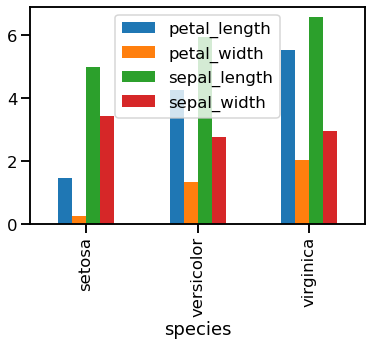

In [47]:
mean_std_df['mean'].plot(kind='bar')

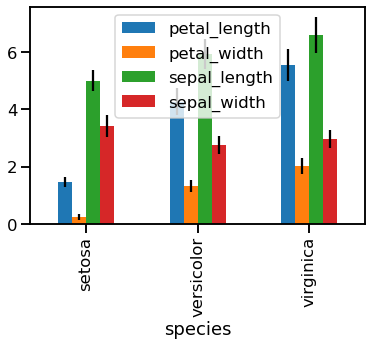

In [48]:
mean_std_df['mean'].plot(kind='bar', yerr=mean_std_df['std'])

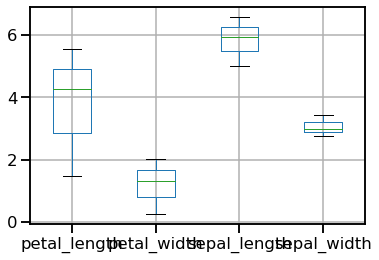

In [49]:
mean_std_df['mean'].boxplot()

# Plotting with seaborn

Seaborn is a statistical plotting package that is designed to plot **LONG dataframes**. Meaning that you only have one numerical value per row.

Do your columns look very redundant? If so they are probably long.

Seaborn natively can make some very impressive summary images

In [50]:
sns.set_context('talk')

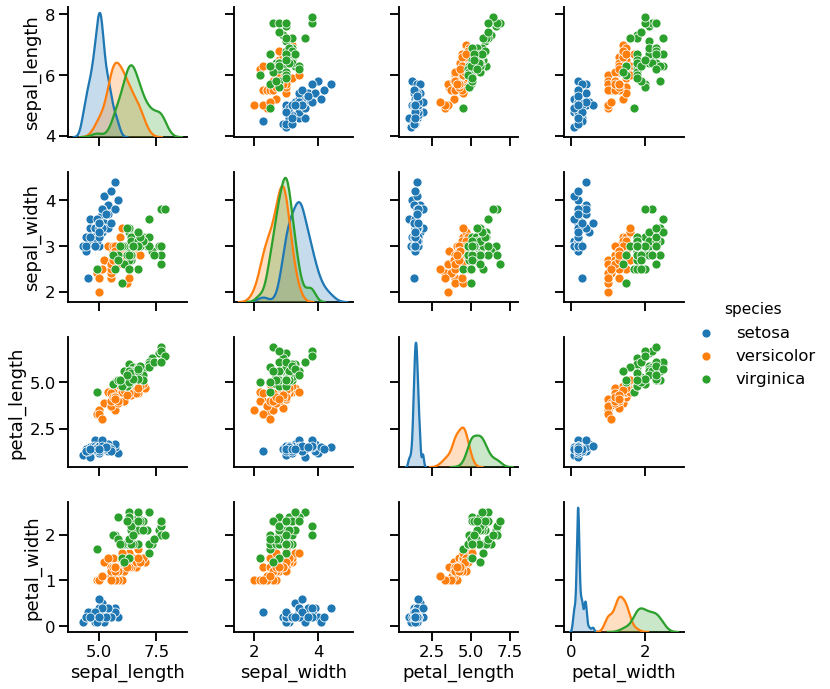

In [51]:
sns.pairplot(data=data_frame, hue="species")

Trying to replicate the bar plots from above

In [52]:
data_frame.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

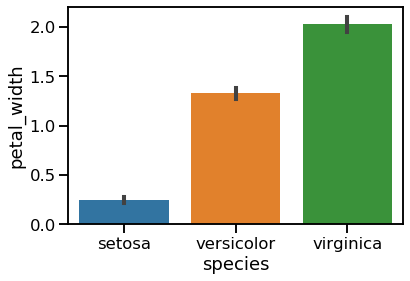

In [53]:
sns.barplot(x='species', y='petal_width', data=data_frame)

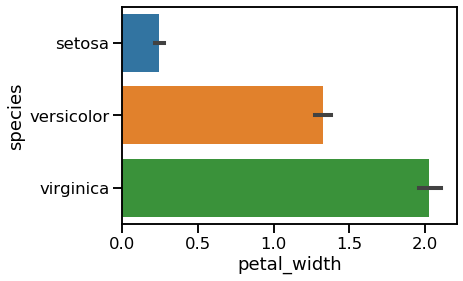

In [54]:
sns.barplot(x='petal_width', y='species', data=data_frame)

If we want to create the above data with the way the data_frame is currently structured we need to build it with a foor loop. 

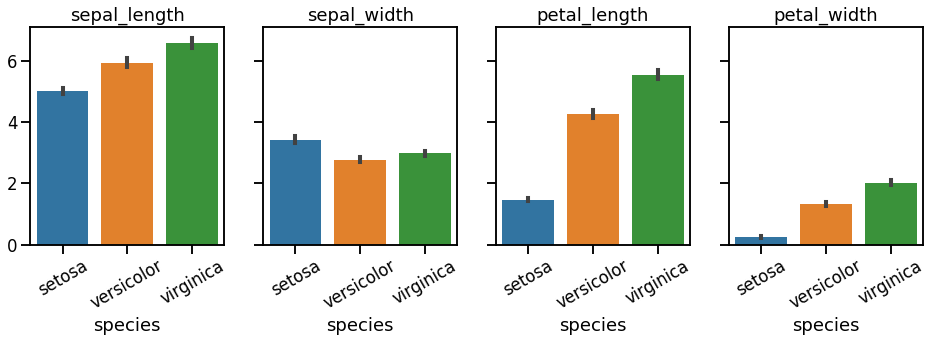

In [0]:
# Making functions using for loops

fig, ax = plt.subplots(ncols=4, nrows=1, sharey=True, sharex=True, figsize=(16, 4))

for fig_ind, category in enumerate(['sepal_length', 'sepal_width', 'petal_length', 'petal_width']):
    sns.barplot(x='species', y=category,
                data=data_frame, ax=ax[fig_ind])
    ax[fig_ind].set_title(category)
    ax[fig_ind].set_ylabel('')
    ax[fig_ind].set_xticklabels(ax[fig_ind].get_xticklabels(), rotation=30)

Let's say we want to do this without using a for loop.... 

We need to mamke our data **even longer!**

In [0]:
melted_data_frame = data_frame.melt(id_vars='species')

In [0]:
melted_data_frame.head()

,species,variable,value
0,setosa,sepal_length,5.1
1,setosa,sepal_length,4.9
2,setosa,sepal_length,4.7
3,setosa,sepal_length,4.6
4,setosa,sepal_length,5.0


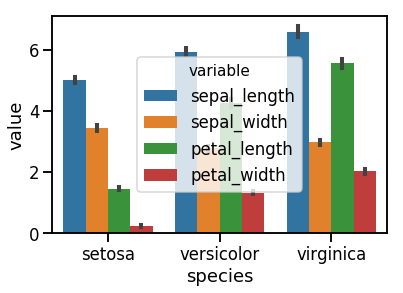

In [0]:
sns.barplot(x='species', y='value', hue='variable', data=melted_data_frame)

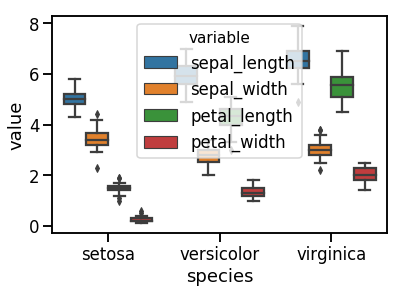

In [0]:
sns.boxplot(x='species', y='value', hue='variable', data=melted_data_frame)

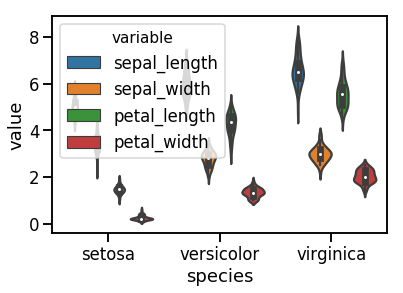

In [0]:
sns.violinplot(x='species', y='value', hue='variable', data=melted_data_frame)

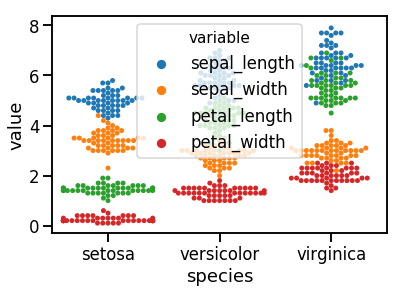

In [0]:
sns.swarmplot(x='species', y='value', hue='variable', data=melted_data_frame)

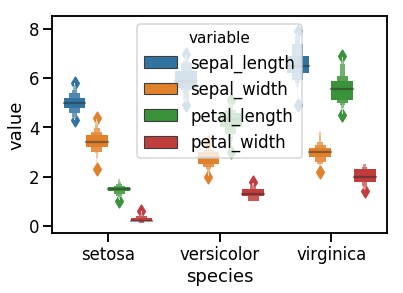

In [0]:
sns.boxenplot(x='species', y='value', hue='variable', data=melted_data_frame)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

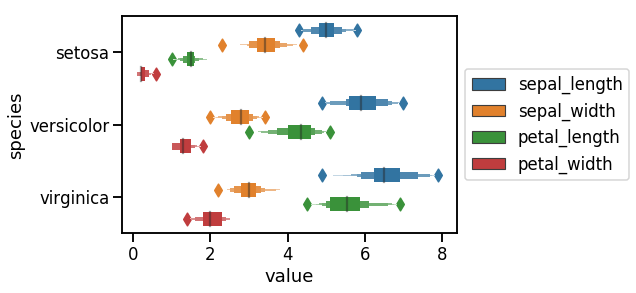

In [0]:
ax = sns.boxenplot(x='value', y='species', hue='variable', data=melted_data_frame)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Looking at dense scatters? Use kde plots.

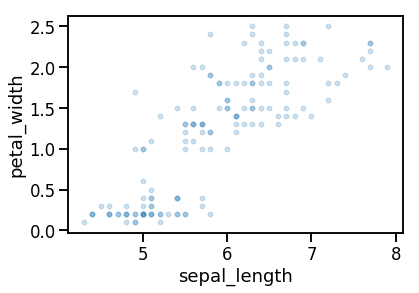

In [0]:
# Alpha controls the opacity of a point

data_frame.plot(x='sepal_length', y='petal_width', kind='scatter', alpha=0.2)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


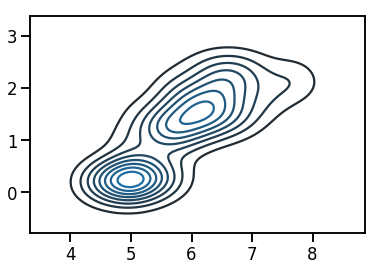

In [0]:
sns.kdeplot(data=data_frame[['sepal_length', 'petal_width']], shade_lowest=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


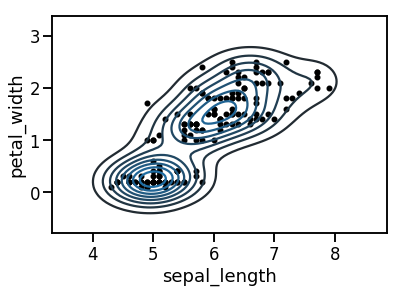

In [0]:
ax = data_frame.plot(x='sepal_length', y='petal_width', kind='scatter', alpha=1, c='k')
sns.kdeplot(data=data_frame[['sepal_length', 'petal_width']], shade_lowest=True, ax=ax)


# Summary plots using both pandas and seaborn

## Coorlation plots

In [0]:
# You can generate a coorelation matrix using pandas

data_frame.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.117570,0.871754,0.817941
sepal_width,-0.117570,1.000000,-0.428440,-0.366126
petal_length,0.871754,-0.428440,1.000000,0.962865
petal_width,0.817941,-0.366126,0.962865,1.000000


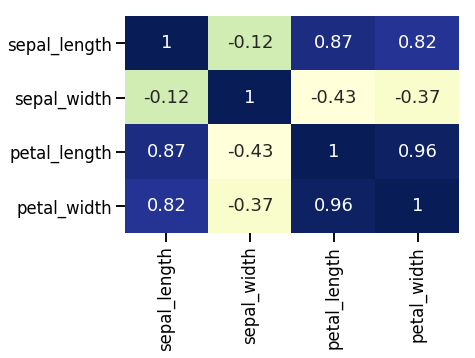

In [0]:
sns.heatmap(data_frame.corr(), annot=True, cmap="YlGnBu", cbar=False)

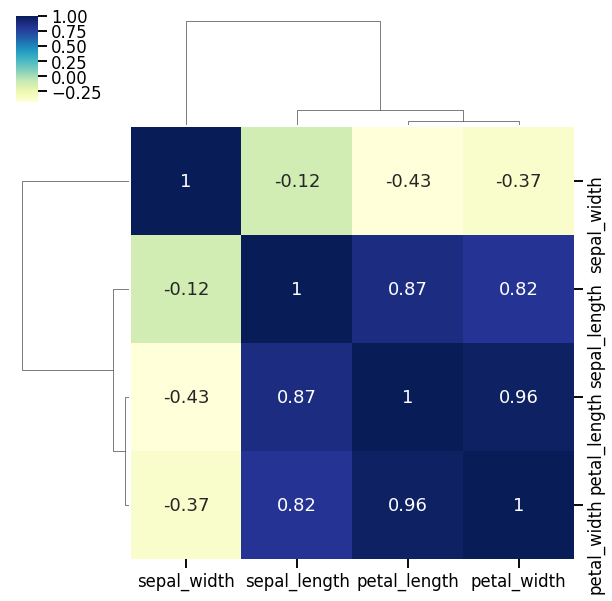

In [0]:
sns.clustermap(data_frame.corr(), annot=True, cmap="YlGnBu")

# A quick look at timeseries data 

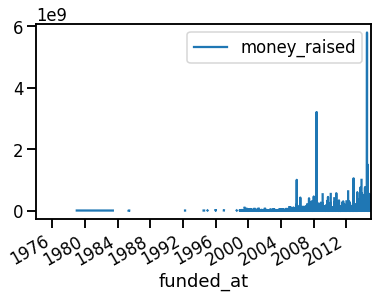

In [0]:
# We can look at how these things change over time

deduped_df.plot(x='funded_at', y='money_raised')

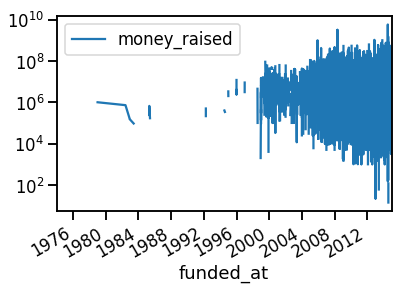

In [0]:
deduped_df.plot(x='funded_at', y='money_raised', logy=True)

In [0]:
# We can do fancy averaging things with seaborn 
# IF we cluster the data together in time
# We are going to do this on a monthly basis

deduped_df['mock_funded_month'] = pd.to_datetime(deduped_df.funded_month)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


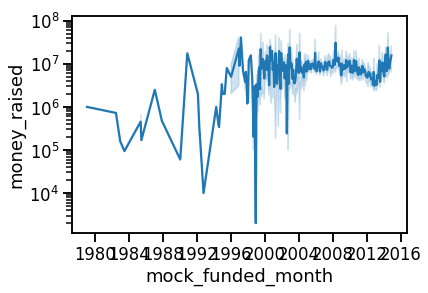

In [0]:
ax = sns.lineplot(data=deduped_df, x='mock_funded_month', y='money_raised')
ax.set_yscale('log')

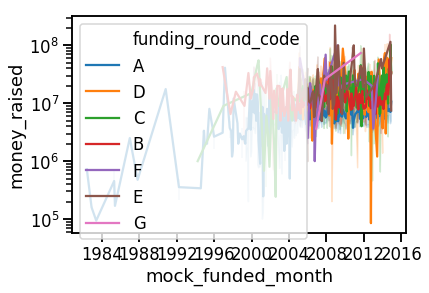

In [0]:
ax = sns.lineplot(data=deduped_df, x='mock_funded_month', y='money_raised', hue='funding_round_code')
ax.set_yscale('log')

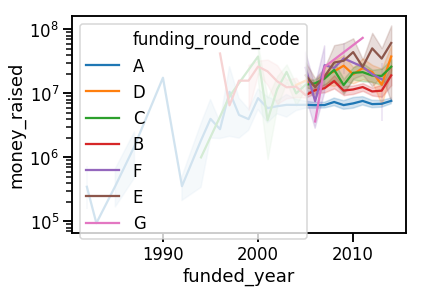

In [0]:
# let's try using year

ax = sns.lineplot(data=deduped_df, x='funded_year', y='money_raised', hue='funding_round_code')
ax.set_yscale('log')